# Poda de ELM utilizando o Algoritmo das Projeções Sucessivas

Como o APS foi proposto como método de seleção de variáveis em problemas de regressão linear múltipla, é direta a sua aplicação na poda de neurônios da camada escondida de ELMs, uma vez que a projeção dos dados entre essa camada e a saída é equivalente a uma regressão linear múltipla.

Desse modo, o APS selecionará colunas da matriz H, cada uma sendo referente a um neurônio, de acordo com a ortogonalidade entre elas. É esperado que seja diminuído o overfitting do modelo com a poda, então deve-se iniciar a rede com muitos neurônios para comparar o desempenho antes e depois da poda.

In [83]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import importlib
from sklearn.preprocessing import normalize

# Estilo para os plots
plt.style.use(['grid', 'science', 'notebook'])

import elm
import aps_utils
importlib.reload(elm)
importlib.reload(aps_utils)
from elm import *
from aps_utils import *

---

## Teste em problema de regressão

In [2]:
# Carregar a base de dados (neste caso, dados de regressão relacionados a diabetes)
regression_data = load_diabetes()
x_reg = regression_data.data
y_reg = regression_data.target

# Separar em conjuntos de treinamento e teste (é importante separar ANTES
# de normalizar, pois não teríamos acesso aos dados de teste de antemão
# na vida real)
x_reg_train, x_reg_test, y_reg_train, y_reg_test = train_test_split(x_reg, y_reg, test_size=0.3, random_state=2003)

# Normalizar os dados entre -1 e 1
x_reg_train_norm, x_reg_test_norm = normalize_by_train(x_reg_train, x_reg_test)
y_reg_train_norm, y_reg_test_norm = normalize_by_train(y_reg_train, y_reg_test)

### Avaliação do erro de treinamento antes da poda

Há 442 amostras no dataset utilizado, então minha rede final pode ter, no máximo, 441 neurônios, pela limitação clássica do APS. Esse valor já é mais do que suficiente para sobreajustar a rede, pois 100 neurônios, nos meus testes anteriores, retornavam um bom modelo.

Como vou utilizar dados de validação no SPA, esse número será um pouco menor, mas ainda deve ser o suficiente para ser utilizado como tamanho máximo da rede.

MSE de treinamento: 3.4915796719157664e-27


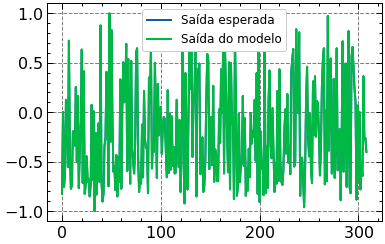

In [3]:
# Treinamento da ELM
n_neurons = x_reg.shape[0]
Z_reg, H_reg, W_reg = train_elm(x_reg_train_norm, y_reg_train_norm, n_neurons, 'lstsq')

# Saída do treinamento (a saída da ELM é linear, então não preciso transformar os dados em problemas
# de regressão)
yhat_reg_train = H_reg@W_reg

# Avaliação do modelo
plt.plot(y_reg_train_norm)
plt.plot(yhat_reg_train)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_train = np.mean((y_reg_train_norm - yhat_reg_train)**2, axis=0)
print(f"MSE de treinamento: {MSE_train}")
plt.show()

Observa-se que o erro de treinamento foi praticamente zero (na ordem de 1e-27), o que indica que o modelo se sobreajustou aos dados de treinamento.

### Avaliação do erro de teste antes da poda

MSE de teste: 4.010046630483526


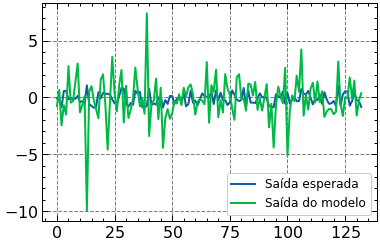

In [4]:
# Teste do modelo
yhat_reg_test = test_elm(x_reg_test_norm, Z_reg, W_reg)

# Avaliação do modelo
plt.plot(y_reg_test_norm)
plt.plot(yhat_reg_test)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_test = np.mean((y_reg_test_norm - yhat_reg_test)**2, axis=0)
print(f"MSE de teste: {MSE_test}")
plt.show()

Como esperado, o erro de teste foi muito alto devido ao overfitting. Agora, vou aplicar a poda e avaliar novamente o resultado.

---

## Poda da rede

Vou utilizar as rotinas desenvolvidas para o APS para podar a rede desenvolvida. Para isso, vou colocar como entrada do modelo a matriz H da ELM inicial.

In [5]:
# Divisão dos dados de treinamento em calibração e validação
#
# Nesse caso, 30% dos dados são destinados para validação.
xcal, xval, ycal, yval = train_test_split(H_reg, y_reg_train_norm, test_size=0.4, random_state=0)

Projections:   0%|          | 0/442 [00:00<?, ?it/s]

Evaluation of variable subsets: 100%|██████████| 442/442 [03:02<00:00,  2.42it/s]


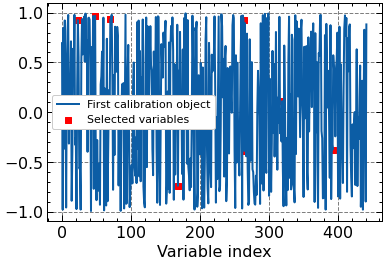


Neurônios selecionados: [ 48 263  23 168 392 319  70 264]


In [6]:
# Execução das duas primeiras fases do SPA
#
# O autor original utiliza a terceira fase também, mas ela não é interessante ainda
# para as aplicações que eu quero dar para o algoritmo
#
# SEL é o conjunto de variáveis selecionadas
M_min = 1
M_max = xcal.shape[0]-1
SEL = spa(xcal, ycal, 
        M_min=M_min, M_max=M_max,
        xval=xval, yval=yval,
        plot=True)
print(f"\nNeurônios selecionados: {SEL}")

### Retreinamento da rede podada

MSE de treinamento: 0.19134401105961762


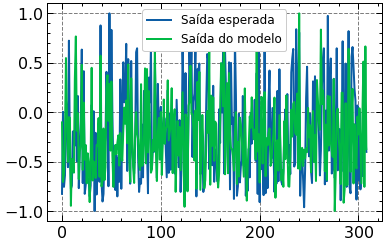

In [7]:
# É necessário obter uma nova matriz de pesos W para a camada de saída após a poda, pois os neurônios
# não são necessariamente independentes
H_pruned_spa, W_pruned_spa = train_pruned_elm(y_reg_train_norm, H_reg, SEL, learning='hebb')

# Normalizando pesos do modelo 
yhat_train_pruned_spa = H_pruned_spa @ W_pruned_spa
yhat_train_pruned_spa = 2*(yhat_train_pruned_spa - np.min(yhat_train_pruned_spa))/(np.max(yhat_train_pruned_spa) - np.min(yhat_train_pruned_spa)) - 1

# Avaliação do modelo
plt.plot(y_reg_train_norm)
plt.plot(yhat_train_pruned_spa)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_train_pruned = np.mean((y_reg_train_norm - yhat_train_pruned_spa)**2, axis=0)
print(f"MSE de treinamento: {MSE_train_pruned}")
plt.show()

Observa-se que foi gerada uma nova solução, dessa vez com erro diferente de zero

### Teste da rede podada

MSE de teste: 0.18731538830066782


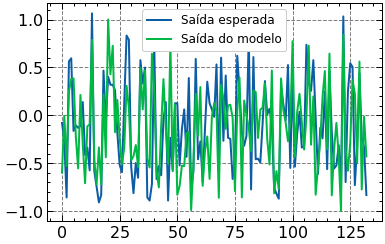

In [8]:
yhat_test_pruned_spa = test_pruned_elm(x_reg_test_norm, Z_reg, W_pruned_spa, SEL)
yhat_test_pruned_spa = 2*(yhat_test_pruned_spa - np.min(yhat_test_pruned_spa))/(np.max(yhat_test_pruned_spa) - np.min(yhat_test_pruned_spa)) - 1

# Avaliação do modelo
plt.plot(y_reg_test_norm)
plt.plot(yhat_test_pruned_spa)
plt.legend(['Saída esperada', 'Saída do modelo'], loc='best', frameon='True', fontsize=12)
MSE_test_pruned = np.mean((y_reg_test_norm - yhat_test_pruned_spa)**2, axis=0)
print(f"MSE de teste: {MSE_test_pruned}")
plt.show()

O modelo podado, mesmo com menos neurônios, foi capaz de gerar uma solução com erro baixo para o conjunto de teste

### Teste de rede com poda aleatória

Ainda é necessário verificar se a poda pelo APS funciona melhor que uma poda aleatória. Para tal, vou gerar uma nova rede podada aleatoriamente com a mesma quantidade de neurônios que a rede podada pelo APS.

Como os neurônios são selecionados aleatoriamente, é necessário calcular diversas vezes o desempenho do modelo para poder tirar conclusões acerca dos resultados.

In [202]:
n_tests = 400
train_mse_history = np.zeros(n_tests)
test_mse_history = np.zeros(n_tests)
xtx_det_history = np.zeros(n_tests)

for i in range(n_tests):
    # Novo conjunto de neurônios selecionados é aleatório (devem ser selecionados sem reposição)
    M_random = SEL.shape[0]
    SEL_random = np.random.choice(H_reg.shape[1]-1, M_random, replace=False)

    # É necessário obter uma nova matriz de pesos W para a camada de saída após a poda, pois os neurônios
    # não são necessariamente independentes
    H_pruned_random, W_pruned_random = train_pruned_elm(y_reg_train_norm, H_reg, SEL_random, learning='hebb')
    yhat_train_pruned_random = H_pruned_random @ W_pruned_random
    yhat_train_pruned_random = 2*(yhat_train_pruned_random - np.min(yhat_train_pruned_random))/(np.max(yhat_train_pruned_random) - np.min(yhat_train_pruned_random)) - 1

    # Teste da rede
    yhat_test_pruned_random = test_pruned_elm(x_reg_test_norm, Z_reg, W_pruned_random, SEL_random)
    yhat_test_pruned_random = 2*(yhat_test_pruned_random - np.min(yhat_test_pruned_random))/(np.max(yhat_test_pruned_random) - np.min(yhat_test_pruned_random)) - 1
    
    # Calcular determinante da matriz de correlação
    xtx_random = H_pruned_random.T @ H_pruned_random
    xtx_random_det = np.linalg.det(xtx_random)

    # Adicionar aos vetores os resultados atuais
    train_mse_history[i] = np.mean((y_reg_train_norm - yhat_train_pruned_random)**2, axis=0)
    test_mse_history[i] =  np.mean((y_reg_test_norm - yhat_test_pruned_random)**2, axis=0)
    xtx_det_history[i] = xtx_random_det
    
mean_train_mse_random = np.mean(train_mse_history)
std_train_mse_random = np.std(train_mse_history)
mean_test_mse_random = np.mean(test_mse_history)
std_test_mse_random = np.std(test_mse_history)
mean_xtx_det_random = np.mean(xtx_det_history)

print(f"""MSE médio de treinamento: {round(mean_train_mse_random, 4)}
Desvio-padrão do MSE do treinamento: {round(std_train_mse_random, 4)}
MSE mínimo do treinamento: {round(np.min(train_mse_history), 4)}
MSE máximo do treinamento: {round(np.max(train_mse_history), 4)}
Determinante médio da matriz XtX: {np.format_float_scientific(mean_xtx_det_random, 2)}

MSE médio de teste: {round(mean_test_mse_random, 4)}
Desvio-padrão do MSE do teste: {round(std_test_mse_random, 4)}
MSE mínimo do teste: {round(np.min(test_mse_history), 4)}
MSE máximo do teste: {round(np.max(test_mse_history), 4)}""")

MSE médio de treinamento: 0.2607
Desvio-padrão do MSE do treinamento: 0.0654
MSE mínimo do treinamento: 0.1474
MSE máximo do treinamento: 0.4731
Determinante médio da matriz XtX: 4.58e+13

MSE médio de teste: 0.2547
Desvio-padrão do MSE do teste: 0.0735
MSE mínimo do teste: 0.1384
MSE máximo do teste: 0.5306


In [186]:
xtx_spa = H_pruned_spa.T @ H_pruned_spa
xtx_spa_det = np.linalg.det(xtx_spa)
print(f"Determinante da matrix XtX do APS: {np.format_float_scientific(xtx_spa_det, 2)}")

Determinante da matrix XtX do APS: 6.99e+13


Como é proposto pelos autores do algoritmo, o APS é uma heurística para a maximização do determinante da matriz de correlação (não escalonada) XtX. Os testes demonstraram que, em média o APS é capaz de gerar um determinante maior para XtX do que a poda aleatória.

---

## Estudo da relação da ortogonalização feita pelo APS com o crosstalk hebbiano

O crosstalk (interferência cruzada) surge como um erro de treinamento em modelos hebbianos devido à não-ortogonalidade entre os dados. Como o APS propõe minimizar a colinearidade entre as variáveis de entrada, isso pode ajudar o treinamento pela regra de Hebb ao diminuir o crosstalk dos modelos.

Vou testar essa possibilidade para ELMs com a camada de saída treinada por Hebb e poda feita pelo APS. Serão gerados diferentes modelos (diferentes números de neurônios iniciais e matriz Z) para um mesmo conjunto de treinamento e esses modelos serão podados utilizando o Algoritmo das Projeções Sucessivas. O crosstalk e o determinante da matriz XtX (nesse caso, HtH) serão calculados para as redes podadas e um gráfico de dispersão será feito (crosstalk versus determinante).

In [210]:
from IPython.display import clear_output

# Cada poda está demorando, em média, 5 minutos pra ser feita, então vou gerar 10 modelos diferentes
# para os testes serem realizados em cerca de 1 hora

n_tests_crosstalk = 15

crosstalk_pruned = np.zeros(n_tests_crosstalk)
xtx_det_pruned = np.zeros(n_tests_crosstalk)

for i in range(n_tests_crosstalk):
    
    print(f"\nTeste n°: {i+1}/{n_tests_crosstalk}")
    
    # Em cada teste, o número de neurônios na rede inicial será escolhido aleatoriamente entre
    # o número de variáveis do dataset e 500
    n_neurons_crosstalk = np.random.randint(x_reg_train_norm.shape[1], 500)
    _, H_init, _ = train_elm(x_reg_train_norm, y_reg_train_norm, n_neurons_crosstalk, 'hebb')
    
    # Divisão dos dados de entrada (matriz H) em calibração e validação
    #
    # Nesse caso, 40% dos dados são destinados para validação.
    xcal, xval, ycal, yval = train_test_split(H_init, y_reg_train_norm, test_size=0.4, random_state=0)
    
    # Poda da rede
    M_min = 1
    #M_max = min(xcal.shape[0]-1, xcal.shape[1]-1)
    M_max = 25
    SEL = spa(xcal, ycal, 
            M_min=M_min, M_max=M_max,
            xval=xval, yval=yval,
            plot=False)
    
    # Cálculo do crosstalk após a poda
    H_pruned = H_init[:,SEL]
    crosstalk_pruned[i] = np.mean(get_crosstalk(H_pruned, y_reg_train_norm))
    H_pruned_norm = normalize(H_pruned, axis=0, norm='l2')
    xtx_det_pruned[i] = np.linalg.det(H_pruned_norm.T @ H_pruned_norm)
    
    clear_output(wait=True)


Teste n°: 15/15


Evaluation of variable subsets: 100%|██████████| 222/222 [00:01<00:00, 179.66it/s]


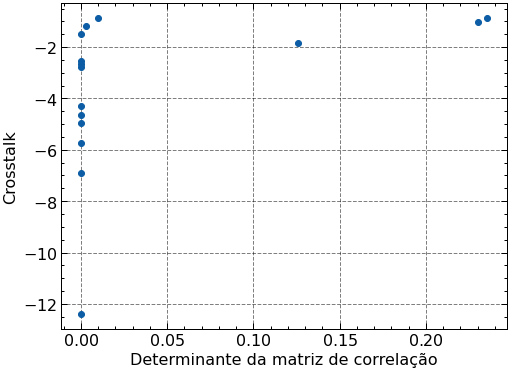

In [211]:
plt.scatter(x=xtx_det_pruned, y=crosstalk_pruned)
plt.xlabel("Determinante da matriz de correlação")
plt.ylabel("Crosstalk")
plt.show()

A princípio, a ortogonalização não parece estar ajudando na redução do crosstalk. Isso pode ser devido à demanda do aprendizado hebbiano por **observações** ortogonais na matriz de dados, e não colunas (neurônios, no caso da camada intermediária de ELM).

---

## Seleção de amostras por APS

O aprendizado hebbiano precisa que as **linhas** da matriz de entrada de dados sejam ortogonais para que o erro de treinamento seja nulo. Ao realizar a poda, tenta-se atingir uma condição de maior ortogonalidade nas linhas ortogonalizando as colunas, realizando efetivamente uma poda na rede. Porém, também é possível selecionar diretamente as amostras de modo a aumentar sua ortogonalidade.

Para isso, basta aplicar o APS nas linhas da matriz de entrada de dados ao invés das colunas, como proposto no artigo que primeiro abordou a seleção de amostras com esse algoritmo. Uma limitação é que o número de variáveis no modelo será, no mínimo, igual ao número de amostras, tornando o problema superdimensionado. No treinamento com mínimos quadrados, isso é um problema porque o modelo se sobreajusta muito facilmente aos dados de entrada, apresentando comportamento ruim nos dados de teste. Porém, no aprendizado hebbiano, o termo de crosstalk serve como regularização, como abordado pelo Euler na tese dele. Isso permite que sistemas mau-condicionados sejam resolvidos fora da solução de erro zero, permitindo maior poder de generalização do treino para o teste.

Para aplicar o APS nas linhas da matriz X, vou trabalhar com a matriz X.T (transposta de X), pois, assim, eu evito mudar muito o algoritmo para trabalhar com linhas ao invés de colunas. Porém, ainda vou ter que mexer um pouco nas funções para fazer a fase 2 do APS, pois ela envolve a construção de modelos de regressão linear múltipla e usa a matriz no formato original.